In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for pre-trained model input
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for pre-trained models
])

In [ ]:
!unzip -qq ./chip_data.zip -d data

unzip:  cannot find or open ./chip_data.zip, ./chip_data.zip.zip or ./chip_data.zip.ZIP.


In [ ]:
dataset_path = "/content/drive/MyDrive/deep learning/chip_data/dataset"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)


In [ ]:
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert tensor format (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

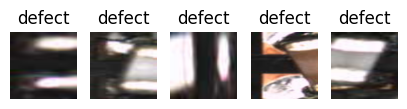

In [ ]:
show_sample_images(train_dataset)

In [ ]:
print(f"Total number of training samples: {len(train_dataset)}")
first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total number of training samples: 172
Shape of the first image: torch.Size([3, 224, 224])


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model=models.vgg19(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 77.2MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
model = models.vgg19(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[-1].in_features
num_classes = len(train_dataset.classes)

model.classifier[-1] = nn.Linear(num_features, 1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
criterion = nn .BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [ ]:
def train_model(model, train_loader,test_loader,num_epochs=10):
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1) # Reshape labels
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Compute validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1) # Reshape labels
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))
        model.train()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Plot training and validation loss
    print("Name:P PARTHIBAN")
    print("Register Number: 212223230145 ")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Epoch [1/5], Train Loss: 0.5486, Validation Loss: 0.4350
Epoch [2/5], Train Loss: 0.4851, Validation Loss: 0.3739
Epoch [3/5], Train Loss: 0.3685, Validation Loss: 0.3397
Epoch [4/5], Train Loss: 0.3369, Validation Loss: 0.3027
Epoch [5/5], Train Loss: 0.2832, Validation Loss: 0.2783
Name:P PARTHIBAN
Register Number: 212223230145 


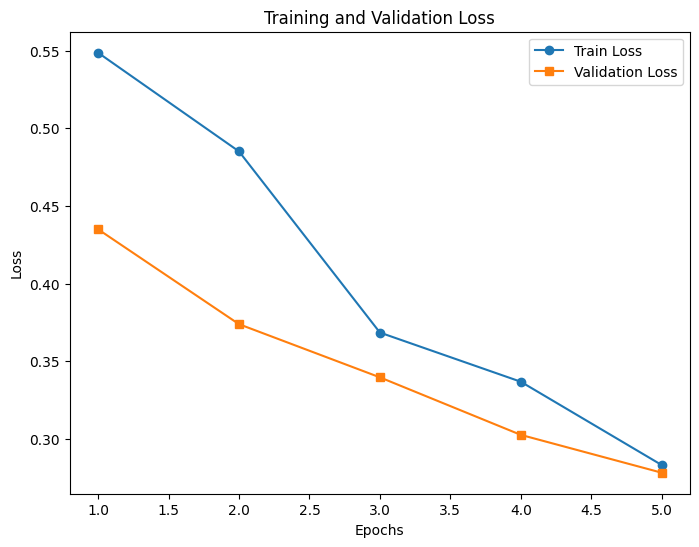

In [ ]:
train_model(model, train_loader,test_loader,num_epochs=5)

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1) # Reshape labels
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).int() # Apply sigmoid and threshold

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Name: P PARTHIBAN      ")
    print("Register Number: 212223230145  ")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Name: P PARTHIBAN    ")
    print("Register Number: 212223230145        ")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

Test Accuracy: 0.9256
Name: P PARTHIBAN      
Register Number: 212223230145  


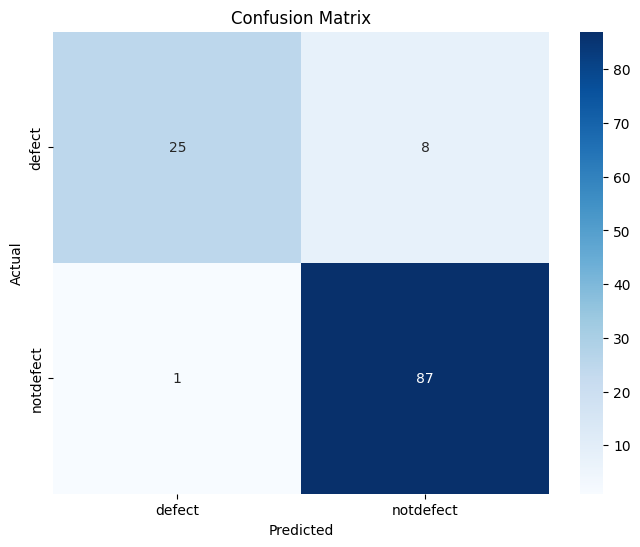

Name: P PARTHIBAN    
Register Number: 212223230145        
Classification Report:
              precision    recall  f1-score   support

      defect       0.96      0.76      0.85        33
   notdefect       0.92      0.99      0.95        88

    accuracy                           0.93       121
   macro avg       0.94      0.87      0.90       121
weighted avg       0.93      0.93      0.92       121



In [ ]:
test_model(model,test_loader)

In [ ]:
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)

        # Apply sigmoid to get probability, threshold at 0.5
        prob = torch.sigmoid(output)
        predicted = (prob > 0.5).int().item()


    class_names = class_names = dataset.classes
    # Display the image
    image_to_display = transforms.ToPILImage()(image)
    print("Name: P PARTHIBAN")
    print("Register Number: 212223230145")
    plt.figure(figsize=(4, 4))
    plt.imshow(image_to_display)
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted]}')
    plt.axis("off")
    plt.show()

Name: P PARTHIBAN
Register Number: 212223230145


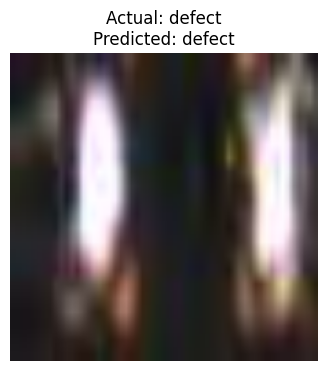

In [ ]:
#Example Prediction
predict_image(model, image_index=14, dataset=test_dataset)